In [1]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# matplotlib formatting
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

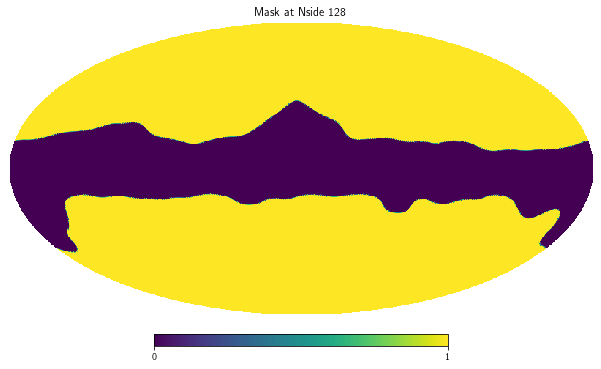

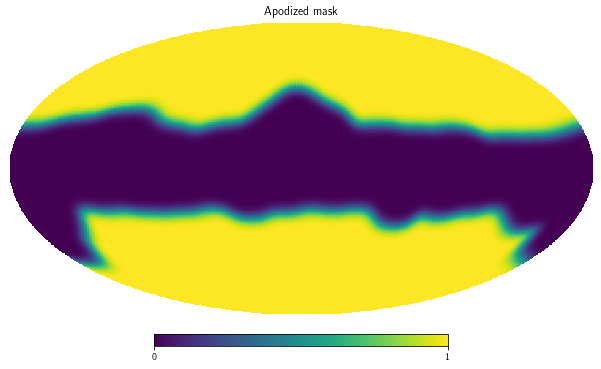

In [3]:
# read in a planck mask, lower resolution, and apodize it on a scale of ~3 degrees
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 12 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128)
hp.mollview(mask_128, title='Mask at Nside 128')
# save mask
hp.write_map("mask_GAL070_128.fits", mask_128)
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")
hp.mollview(mask, title='Apodized mask')

In [4]:
# set up workings for mkd model

# load component maps
nlayers = 6
nside = 512
npix = hp.nside2npix(nside)
I_layers = np.zeros((nlayers,npix))
Q_layers = np.zeros((nlayers,npix))
U_layers = np.zeros((nlayers,npix))
beta_layers = np.zeros((nlayers,npix))
tdust_layers = np.zeros((nlayers,npix))
for i in range(nlayers):
    (I_layers[i,:], Q_layers[i,:], U_layers[i,:]) = hp.read_map(('thermaldust/thermaldust_ampl%d.fits') % (i+1), 
                                                                field=[0,1,2], verbose=False)
    beta_layers[i,:] = hp.read_map(('thermaldust/thermaldust_specind%d.fits') % (i+1), verbose=False)
    tdust_layers[i,:] = hp.read_map(('thermaldust/thermaldust_temp%d.fits') % (i+1), verbose=False)

# physical constants
c = 2.99792458e10       # Speed of light, cm/s
h = 6.62606957e-27      # Planck constant, erg s
k = 1.3806488e-16       # Boltzmann constant, erg/K

# planck function
def B_nu (nu, T):
    np.seterr(over='ignore')
    return 2.0*h*(nu**3)/(c**2*(np.expm1(h*nu/(k*T))))

# predicts I,Q, or U at a frequency nu in Hz according to T, beta, and a reference frequency
def mbb_scaling(nu, amp, temp, beta, nu_ref):
    return amp * (nu/nu_ref)**beta * B_nu(temp, nu)/B_nu(temp,nu_ref)

In [5]:
# functions that take in a frequency and return map(s) using pysm or mkd
def make_map_pysm(freq):
    return sky.get_emission(freq * u.GHz)
def make_map_mkd(freq):
    # make 217 I, Q, and U maps
    I2_512 = np.sum(mbb_scaling(freq*1e9, I_layers, tdust_layers, beta_layers, 353.e9),axis=0)
    Q2_512 = np.sum(mbb_scaling(freq*1e9, Q_layers, tdust_layers, beta_layers, 353.e9),axis=0)
    U2_512 = np.sum(mbb_scaling(freq*1e9, U_layers, tdust_layers, beta_layers, 353.e9),axis=0)
    # lower nside
    I2 = hp.pixelfunc.ud_grade(I2_512, 128)
    Q2 = hp.pixelfunc.ud_grade(Q2_512, 128)
    U2 = hp.pixelfunc.ud_grade(U2_512, 128)
    # return array of maps
    return [I2,Q2,U2]

In [6]:
# functions that take in a map, the map_217, the cl1x1 value, and the map 217 field and outputs r80 value for BB, EE, or TT
def rbb80(map_nu2, clbb1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_b = True)
    clbb1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[3][6]
    clbb2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[3][6]
    return clbb1x2/(np.sqrt(clbb1x1*clbb2x2))
def ree80(map_nu2, clee1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_e = True)
    clee1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[0][6]
    clee2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[0][6]
    return clee1x2/(np.sqrt(clee1x1*clee2x2))
def rtt80(map_nu2, cltt1x1, f0_map_nu1, mask):
    # initialize spin-0 field for map2
    f0_map_nu2 = nmt.NmtField(mask, [map_nu2])
    cltt1x2 = nmt.compute_full_master(f0_map_nu1, f0_map_nu2, b)[0][6]
    cltt2x2 = nmt.compute_full_master(f0_map_nu2, f0_map_nu2, b)[0][6]
    return cltt1x2/(np.sqrt(cltt1x1*cltt2x2))  

In [8]:
freqs = np.arange(150,3000,150)
rbb80_vals = np.ones((len(freqs),10))*1.
ree80_vals = np.ones((len(freqs),10))*1.
rtt80_vals = np.ones((len(freqs),10))*1.
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 10 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)

# for all of the pysm models
for i in range(9):
    # make a sky
    sky = pysm3.Sky(nside=128, preset_strings=["d"+str(i)])
    # make 217GHz map
    map_217GHz = sky.get_emission(217 * u.GHz)
    # initialize a spin-2 field for BB & EE and a spin-0 field for TT, compute their cl80 values
    f2_map_nu1_bb = nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
    clbb1x1 = nmt.compute_full_master(f2_map_nu1_bb, f2_map_nu1_bb, b)[3][6]
    f2_map_nu1_ee = nmt.NmtField(mask, map_217GHz[1:,:], purify_e = True)
    clee1x1 = nmt.compute_full_master(f2_map_nu1_ee, f2_map_nu1_ee, b)[0][6]
    f0_map_nu1 = nmt.NmtField(mask, [map_217GHz[0]])
    cltt1x1 = nmt.compute_full_master(f0_map_nu1, f0_map_nu1, b)[0][6]
    # compute Rl[80] for every 150GHz from 150GHz to 3THz
    for j, freq in enumerate(freqs):
        map_freq = make_map_pysm(freq)
        rbb80_vals[j][i] = (1 - rbb80(map_freq[1:,:], clbb1x1, f2_map_nu1_bb, mask))
        ree80_vals[j][i] = (1 - ree80(map_freq[1:,:], clee1x1, f2_map_nu1_ee, mask))
        rtt80_vals[j][i] = (1 - rtt80(map_freq[0,:], cltt1x1, f0_map_nu1, mask))

# for the mkd model
#make 217 I, Q, and U maps
I217_512 = np.sum(mbb_scaling(217.e9, I_layers, tdust_layers, beta_layers, 353.e9),axis=0)
Q217_512 = np.sum(mbb_scaling(217.e9, Q_layers, tdust_layers, beta_layers, 353.e9),axis=0)
U217_512 = np.sum(mbb_scaling(217.e9, U_layers, tdust_layers, beta_layers, 353.e9),axis=0)
#lower nside
I217 = [hp.pixelfunc.ud_grade(I217_512, 128)]
Q217 = hp.pixelfunc.ud_grade(Q217_512, 128)
U217 = hp.pixelfunc.ud_grade(U217_512, 128)
#array of maps
maps_nu1_iqu = [I217,Q217,U217]

# initialize a spin-2 field, compute it's clee80 value
f2_map217_bb = nmt.NmtField(mask, maps_nu1_iqu[1:], purify_b = True)
clbb1x1 = nmt.compute_full_master(f2_map217_bb, f2_map217_bb, b)[3][6]
f2_map217_ee = nmt.NmtField(mask, maps_nu1_iqu[1:], purify_e = True)
clee1x1 = nmt.compute_full_master(f2_map217_ee, f2_map217_ee, b)[0][6]
# initialize a spin-0 field, compute it's cltt80 value
f0_map217 = nmt.NmtField(mask, maps_nu1_iqu[0])
cltt1x1 = nmt.compute_full_master(f0_map217, f0_map217, b)[0][6]
for j, freq in enumerate(freqs):
    map_freq_mkd = make_map_mkd(freq)
    rbb80_vals[j][9] = (1 - rbb80(map_freq_mkd[1:], clbb1x1, f2_map217_bb, mask))
    ree80_vals[j][9] = (1 - ree80(map_freq_mkd[1:], clee1x1, f2_map217_ee, mask))
    rtt80_vals[j][9] = (1 - rtt80(map_freq_mkd[0], cltt1x1, f0_map217, mask))
np.savetxt("rbb80_vals217_3.txt", rbb80_vals)
np.savetxt("ree80_vals217_3.txt", ree80_vals)
np.savetxt("rtt80_vals217_3.txt", rtt80_vals)

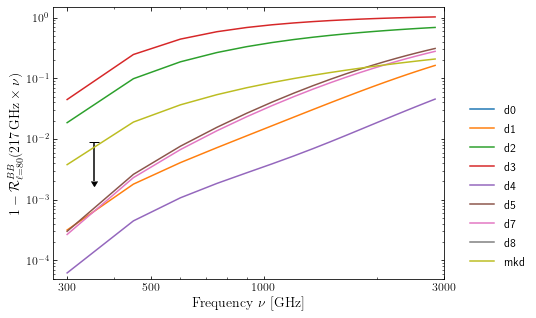

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

models = np.array([0,1,2,3,4,5,7,8,9])
for i, model in enumerate(models):
    if model == 9:
        ax.plot(freqs[1:], rbb80_vals[1:,model], label= 'mkd')
    else:
        ax.plot(freqs[1:], rbb80_vals[1:,model], label= 'd'+str(model))
ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('all_models_217_bb3.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

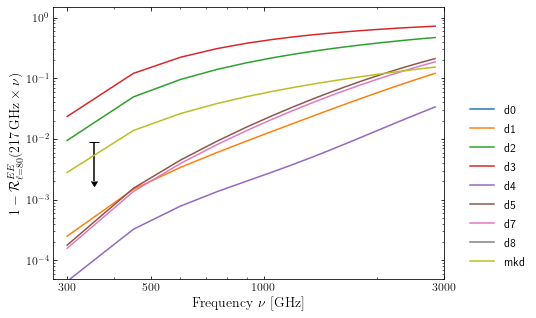

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{EE}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

models = np.array([0,1,2,3,4,5,7,8,9])
for i, model in enumerate(models):
    if model == 9:
        ax.plot(freqs[1:], ree80_vals[1:,model], label= 'mkd')
    else:
        ax.plot(freqs[1:], ree80_vals[1:,model], label= 'd'+str(model))
ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('all_models_217_ee3.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

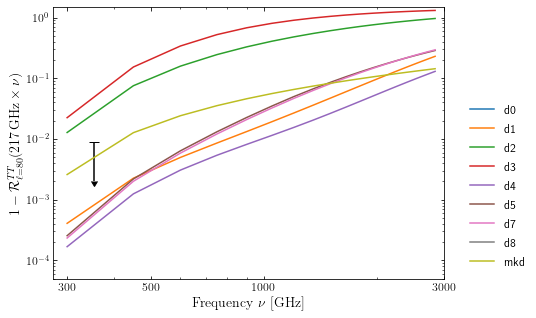

In [11]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{TT}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

models = np.array([0,1,2,3,4,5,7,8,9])
for i, model in enumerate(models):
    if model == 9:
        ax.plot(freqs[1:], rtt80_vals[1:,model], label= 'mkd')
    else:
        ax.plot(freqs[1:], rtt80_vals[1:,model], label= 'd'+str(model))
ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('all_models_217_tt3.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')